In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
cd '/content/drive/Shareddrives/M202A Embedded Systems Project/data'

/content/drive/Shareddrives/M202A Embedded Systems Project/data


In [74]:
import numpy as np
import pandas as pd
from os import listdir
import os.path
import zipfile
from keras.utils.np_utils import to_categorical
import json
from sklearn.model_selection import train_test_split

In [75]:
def get_header():
    header = ["acc_x", "acc_y","acc_z", "gyro_x", "gyro_y","gyro_z", "activityID"]
    return header

def addheader(datasets):
    """
    The columns of the pandas data frame are numbers
    this function adds the column labels
    Parameters
    ----------
    datasets : list
        List of pandas dataframes
    """
    header = get_header()
    for i in range(0, len(datasets)):
        datasets[i].columns = header
    return datasets

In [76]:
def clip_data(ds):
  '''
  Takes in a data set and slices it to the first activityID and last activityID
  Inputs:
    - ds: a pandas dataset
  Returns:
    - ds: sliced pandas dataset, starting at the first nonzero activity ID and ending at the last nonzero activityID
  '''
  return ds[ds[ds.activityID != 0].first_valid_index():ds[ds.activityID != 0].last_valid_index()+1]

In [77]:
def label_move(ds):
  '''
  Takes a data set in the form of [1, 0, ..., 2, 2, ... 0, 0,... n] and classifies the difference between key presses
  '''
  classifier_dict = {
      1  : 1,
      2  : 2,
      3  : 3,
      4  : 4,
      -1 : -1,
      -2 : -2,
      -3 : -3,
      -4 : -4
  }
  # Shorten the presses array to remove consecutive duplicates. [1, 2, 2, 2, 3, 3, 3, 2,...] -> [1, 2, 3, 2...]
  presses = [val for val in ds if val != 0] # remove 0's
  presses_short = []
  lru_val = None
  for i in range(len(presses)):
    if i == 0:
      presses_short.append(presses[i])
      lru_val = presses[i]
    else:
      if presses[i] != lru_val:
        presses_short.append(presses[i])
        lru_val = presses[i]
  # Create an array of the differences from the shortened presses list. [1, 2, 3, 2...] -> [1, 1, -1...]
  diffs = []
  for i in range(len(presses_short)):
    try:
      diffs.append(presses_short[i+1] - presses_short[i])
    except IndexError:
      pass
  # Use the classifier dictionary to change negative movement to positive values
  motions = [classifier_dict[val] for val in diffs]
  # Go back and update ds with the motions
  motions_idx = -1
  new_ds = []
  lru_val = None
  for val in ds:
    if lru_val == None:
      new_ds.append(0)
    else:
      if val == lru_val:
        if val == 0:
          new_ds.append(motions[motions_idx])
        else:
          new_ds.append(0)
      else:
        if val == 0:
          motions_idx += 1
          new_ds.append(motions[motions_idx])
        else:
          new_ds.append(0)
    lru_val = val
  return new_ds

In [78]:
def sliding_window(frame_length, step, Xsampleslist, ysampleslist):
    """
    Splits time series in ysampleslist and Xsampleslist
    into segments by applying a sliding overlapping window
    of size equal to frame_length with steps equal to step
    it does this for all the samples and appends all the output together.
    So, the participant distinction is not kept
    Parameters
    ----------
    frame_length : int
        Length of sliding window
    step : int
        Stepsize between windows
    Xsamples : list
        Existing list of window fragments
    ysamples : list
        Existing list of window fragments
    Xsampleslist : list
        Samples to take sliding windows from
    ysampleslist
        Samples to take sliding windows from
    """
    Xsamples = []
    ysamples = []
    for j in range(len(Xsampleslist)):
        X = Xsampleslist[j]
        y = ysampleslist[j]
        for i in range(0, X.shape[0] - frame_length, step):
            xsub = X[i:i + frame_length, :]
            ysub = 0
            for z in range(i,i + frame_length + 1, 1):
              if y[z] == 1:
                ysub = 1
              elif y[z] == 2:
                ysub = 2
              elif y[z] == 3:
                ysub = 3
              elif y[z] == 4:
                ysub = 4
              elif y[z] == 5:
                ysub = 5
            # ysub = y
            Xsamples.append(xsub)
            ysamples.append(ysub)
    return Xsamples, ysamples

In [79]:
columns_to_use = ["acc_x", "acc_y","acc_z", "gyro_x", "gyro_y","gyro_z"]

datadir = os.path.join('/content/drive/Shareddrives/M202A Embedded Systems Project/data');
filenames = os.listdir(datadir)
filenames.sort()
datasets = [pd.read_csv(os.path.join(datadir, fn), header=None, sep=',')
            for fn in filenames]
#print(datasets)
datasets = addheader(datasets)
datasets_filled = [d.interpolate() for d in datasets]
datasets_clipped = [clip_data(ds) for ds in datasets_filled]

# Create input (x) and output (y) sets
xall = [np.array(data[columns_to_use]) for data in datasets_clipped]
yall = [np.array(data.activityID) for data in datasets_clipped]


In [80]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(xall, yall, test_size=0.20, random_state=9)

In [81]:
# window with 40 samples, each sample has 6 sensor data (acc x,y,z & gyro x,y,z) Thus, total of 240 sensor data in each window
x_tr, y_tr = sliding_window(40,1,X_train,y_train)
x_te, y_te = sliding_window(40,1,X_test,y_test)

motions_y_tr = label_move(y_tr)
motions_y_te = label_move(y_te)


In [82]:
x_tr = np.reshape(x_tr, (-1,240))
x_te = np.reshape(x_te, (-1,240))
y_tr = motions_y_tr
y_te = motions_y_te

In [ ]:
# Import different types of classifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

# model = BaggingClassifier(base_estimator=RandomForestClassifier(),n_estimators=10, random_state=0)
# model = KNeighborsClassifier(n_neighbors=10)
# model = GaussianNB()
# model = RandomForestClassifier(max_depth=10)
# model = DecisionTreeClassifier()
model = LogisticRegression(max_iter=1000)
# model = LinearSVC()

model.fit(x_tr, y_tr)

[ 0  0  0 ... -2 -2 -2]


array([[ 164,   20,    9,    0,    2,    0,    0,    0],
       [   0,   79,   13,    0,    2,    0,    0,    0],
       [   0,   37,  623,  134,   22,    0,    0,    0],
       [   0,    0,    0,  464,   23,    0,    0,    0],
       [   2,    1,   11,    4, 2355,    6,   27,    4],
       [   0,    0,    0,    0,   12,  316,    0,    0],
       [   0,    0,    0,    0,   38,   30, 1094,   16],
       [   0,    0,    0,    0,    0,    1,    6,   74]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


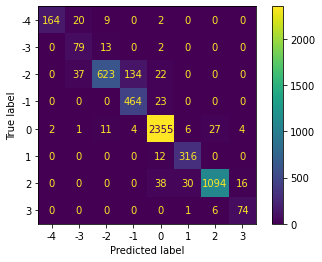

Accuracy = 0.92485


In [84]:
predictions = model.predict(x_te)
print(predictions)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix

cm = confusion_matrix(y_te, predictions)
display(cm)

accuracy = accuracy_score(y_te, predictions)

plot_confusion_matrix(model, x_te, y_te)  
plt.show()
print('Accuracy = {:0.5f}'.format(accuracy))